In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# %cd /content/drive/MyDrive/Classifier_Parameters_Searching

/content/drive/MyDrive/Classifier_Parameters_Searching


In [3]:
# !pip install optuna --quiet
# !pip install catboost --quiet

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score , GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, roc_auc_score, matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score, f1_score, average_precision_score
from sklearn.metrics import roc_auc_score, fbeta_score, recall_score, confusion_matrix, accuracy_score
import time
import joblib
from utils.ncv import EstWithNest
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
hepatis=pd.read_csv("Hepatitis_C.csv")

In [4]:
hepatis.head()

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,label
0,32,0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0
1,45,0,41.7,73.2,43.6,29.4,6.4,8.89,5.31,71.0,67.4,70.3,0
2,55,0,41.5,59.5,15.4,16.2,6.8,6.35,5.22,80.0,12.4,69.9,0
3,53,0,37.8,98.1,30.5,21.1,4.0,5.02,4.42,94.0,23.2,65.2,0
4,56,1,39.7,66.0,14.2,20.8,3.5,7.48,5.88,66.0,7.2,67.2,0


## Data Exploration

In [12]:
# chech if we have null or NaN values
counter_null=hepatis[hepatis.columns].isnull().all(axis=1).sum()
counter_na=hepatis[hepatis.columns].isna().all(axis=1).sum()
print(counter_null,counter_na)

0 0


In [13]:
# check the types of the data frame
hepatis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     204 non-null    int64  
 1   Sex     204 non-null    int64  
 2   ALB     204 non-null    float64
 3   ALP     204 non-null    float64
 4   ALT     204 non-null    float64
 5   AST     204 non-null    float64
 6   BIL     204 non-null    float64
 7   CHE     204 non-null    float64
 8   CHOL    204 non-null    float64
 9   CREA    204 non-null    float64
 10  GGT     204 non-null    float64
 11  PROT    204 non-null    float64
 12  label   204 non-null    int64  
dtypes: float64(10), int64(3)
memory usage: 20.8 KB


In [14]:
hepatis.describe()

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,label
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,47.779412,0.357843,41.200490,66.647549,29.841618,48.688725,16.460294,7.934951,5.212157,86.037255,55.117157,72.811765,0.333333
std,10.615323,0.480545,5.656545,33.630161,30.205844,50.826309,29.763884,2.569216,1.128499,83.340139,78.465442,5.581961,0.472564
min,19.000000,0.000000,20.000000,11.300000,0.900000,12.200000,1.800000,1.420000,1.430000,8.000000,7.000000,51.000000,0.000000
25%,40.000000,0.000000,38.950000,52.000000,14.900000,22.425000,5.800000,6.637500,4.445000,66.625000,18.600000,70.000000,0.000000
50%,48.000000,0.000000,41.900000,62.700000,21.500000,29.800000,8.800000,7.970000,5.220000,75.600000,28.700000,72.750000,0.000000
75%,56.000000,1.000000,45.000000,76.250000,35.025000,47.500000,14.025000,9.652500,5.957500,86.250000,64.200000,76.100000,1.000000
max,76.000000,1.000000,62.900000,416.600000,258.000000,324.000000,254.000000,16.410000,8.280000,1079.100000,650.900000,90.000000,1.000000


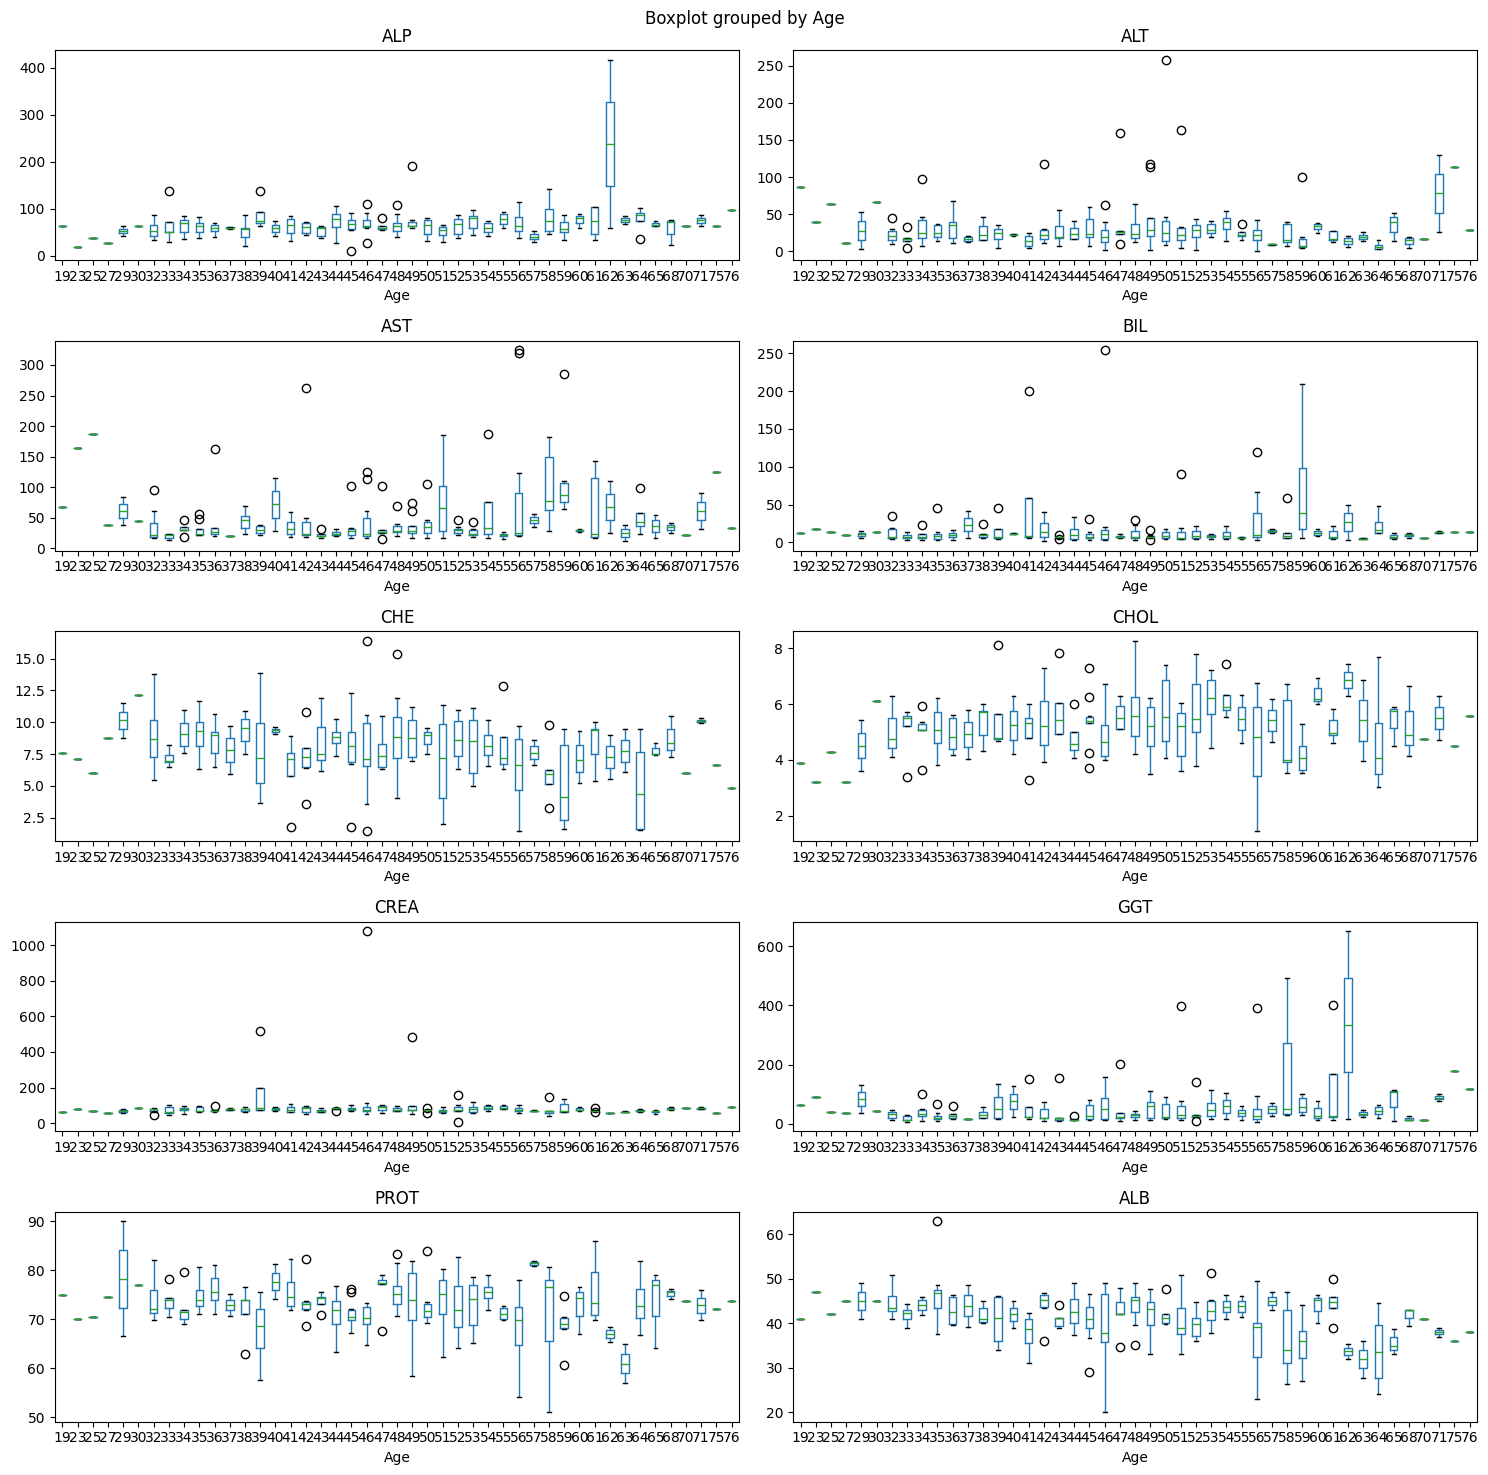

In [15]:
# create a grid of subplots with 2 columns and 5 rows
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,15))

for i, col in enumerate(hepatis.columns):
    if not (col=='Age' or col=='label' or col=='Sex'):
        ax=axes.flatten()[i-3]
        hepatis.boxplot(by='Age',column=[col],ax=ax,grid=False)
        ax.set_title(col)

plt.tight_layout()
plt.show()

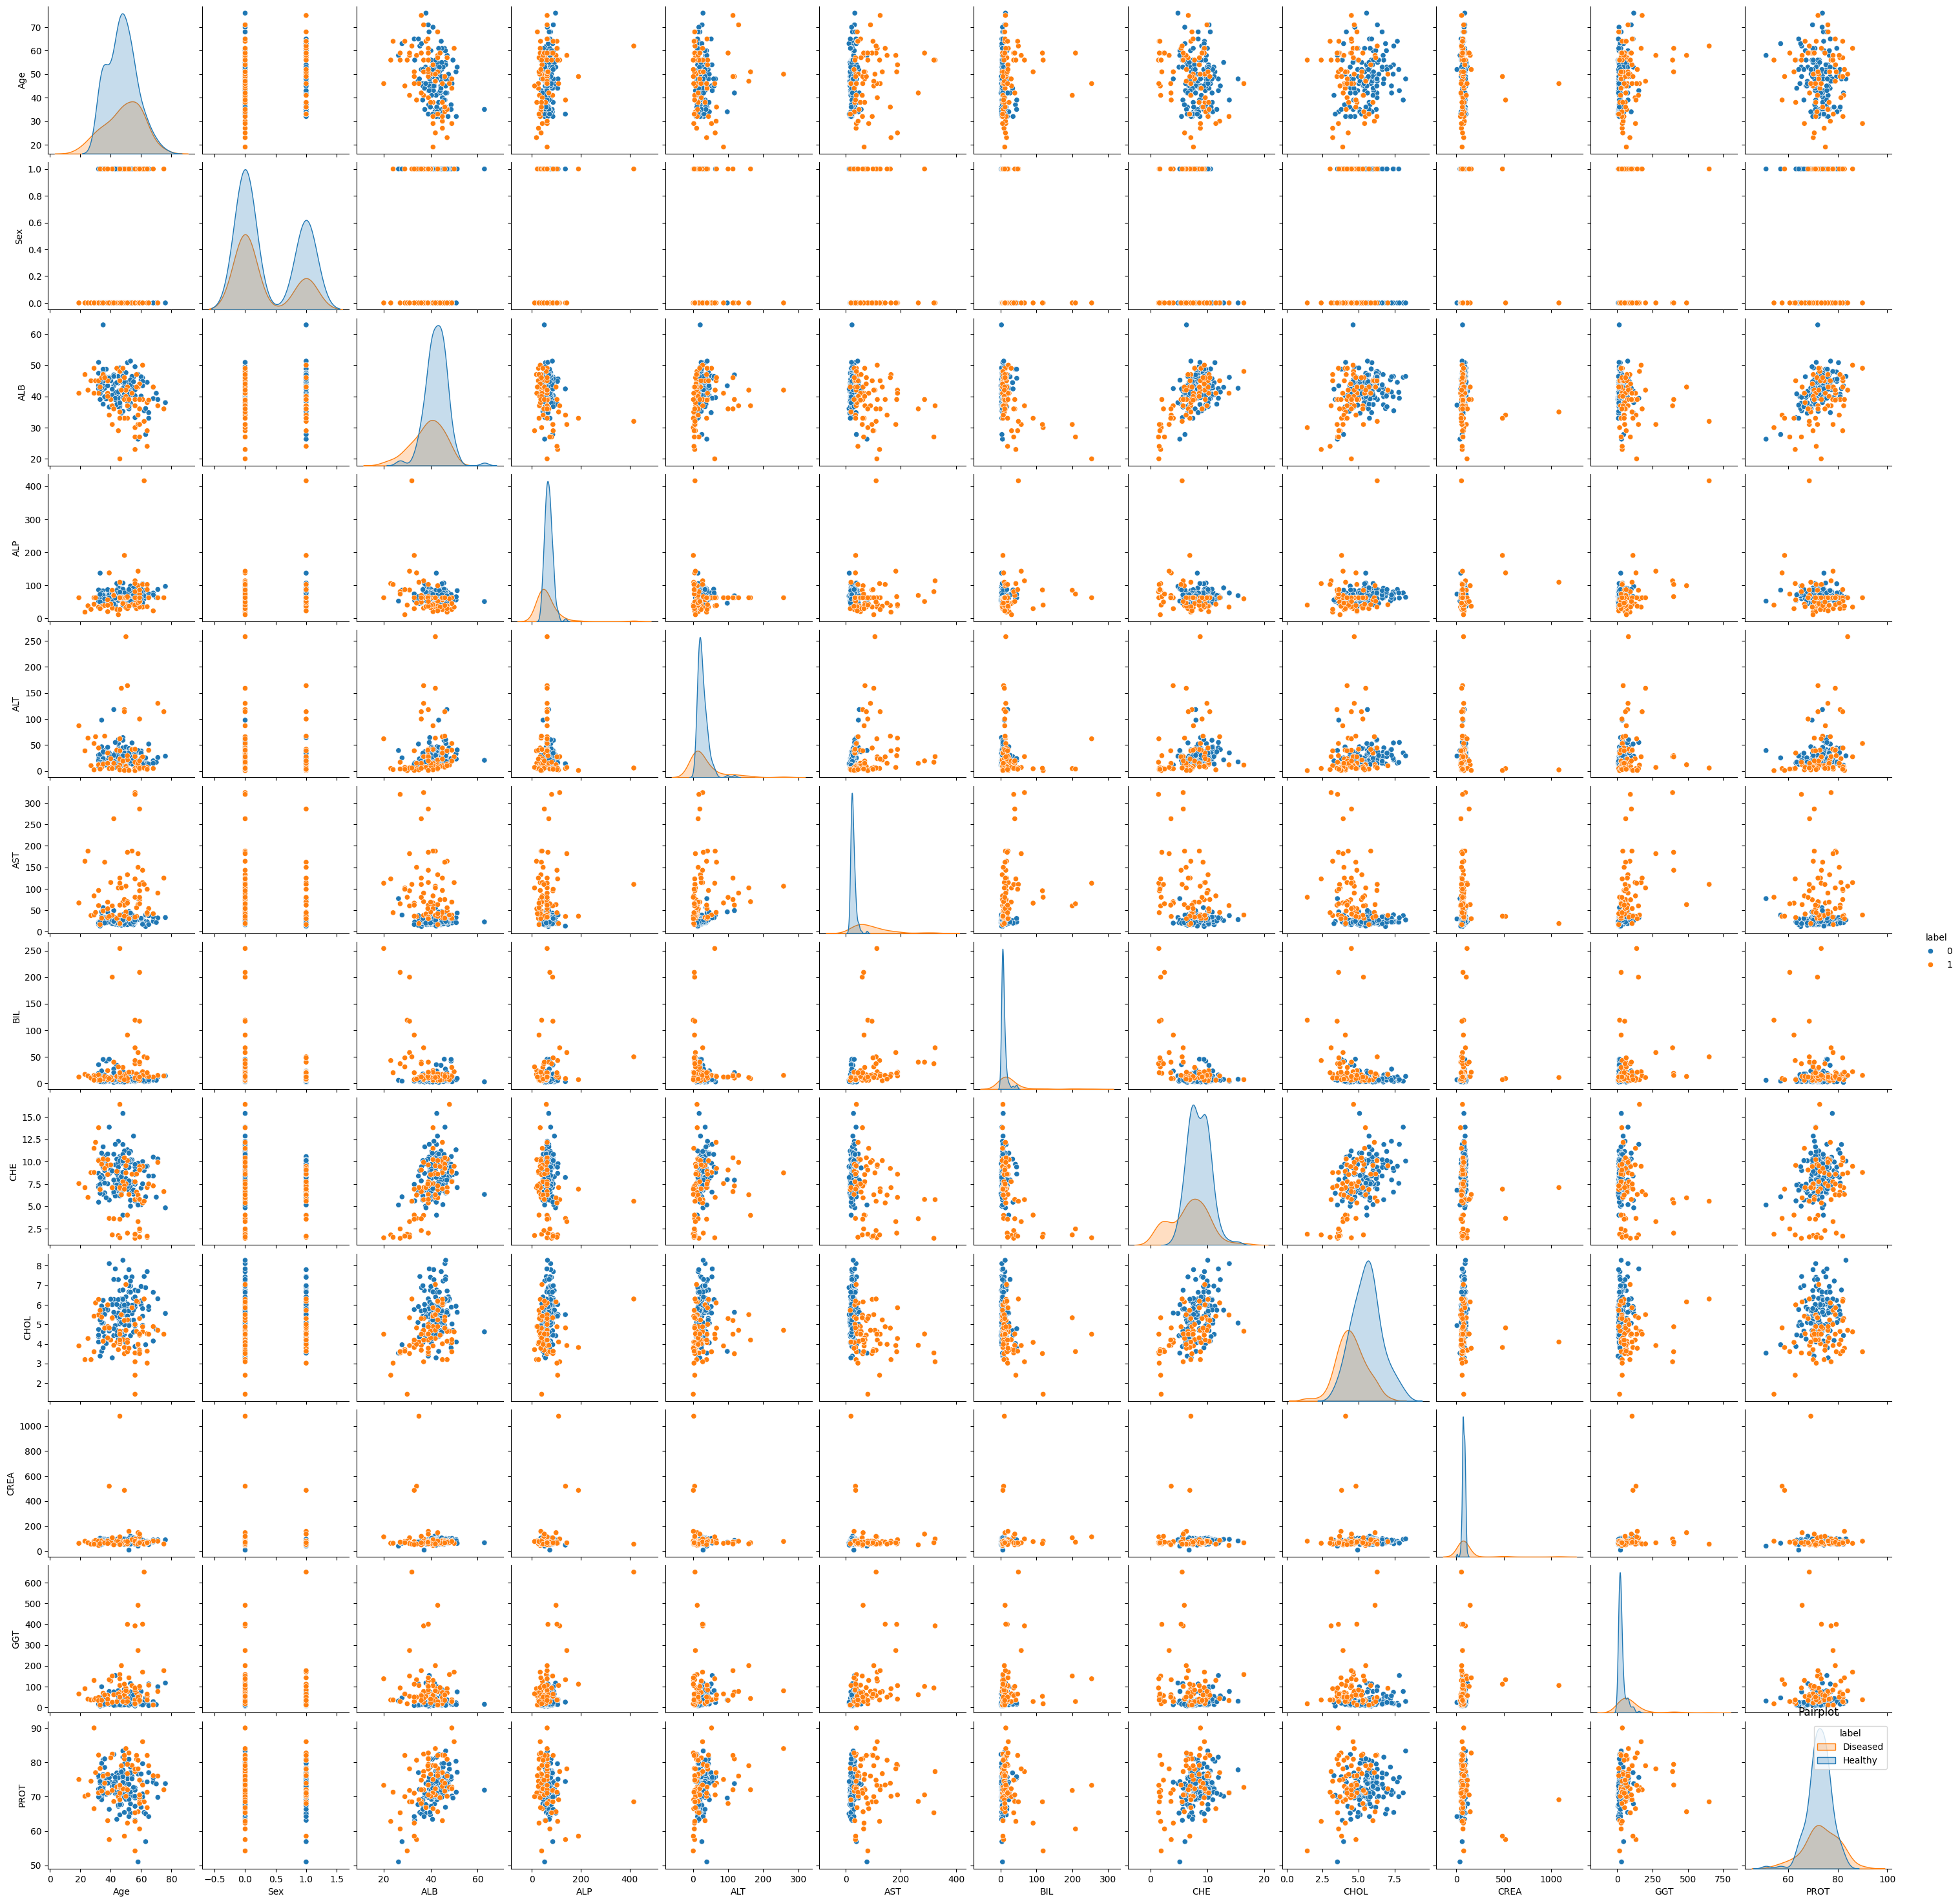

In [16]:
sns.pairplot(hepatis, hue='label')
plt.legend(title='label', loc='upper right', labels=['Diseased', 'Healthy'])
plt.title('Pairplot')
plt.show()

There are no observable and clear correlations between the data.

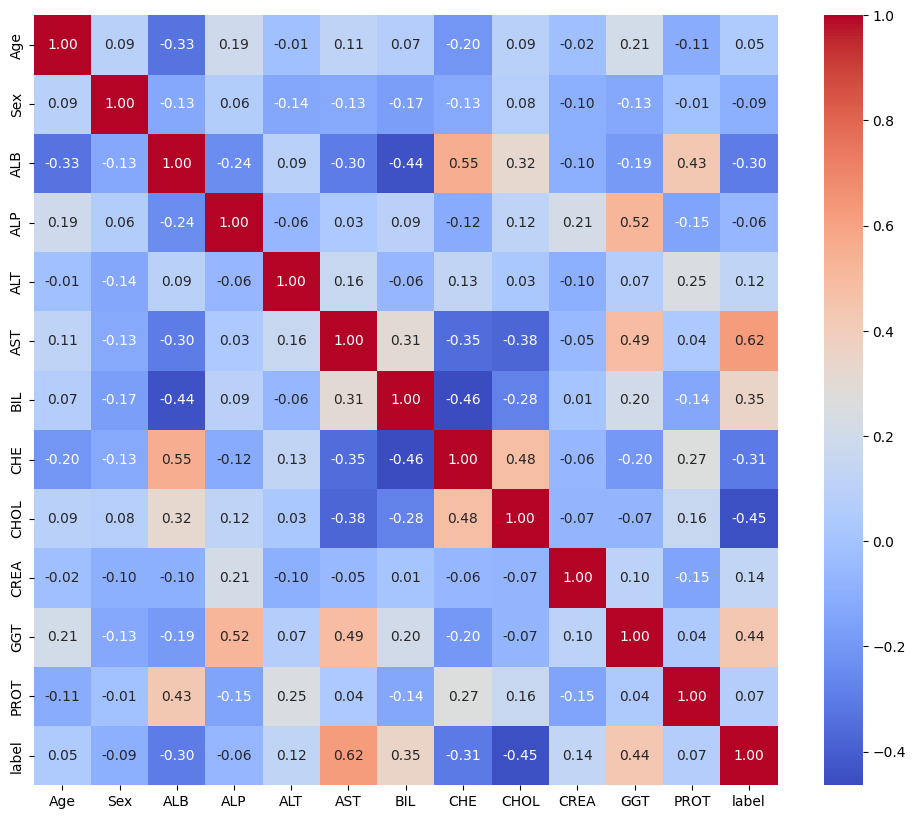

In [17]:
correlations = hepatis.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, cmap='coolwarm', annot=True, fmt='.2f')
plt.show()

<Axes: title={'center': 'Top Correlation Values'}, xlabel='None', ylabel='correlation'>

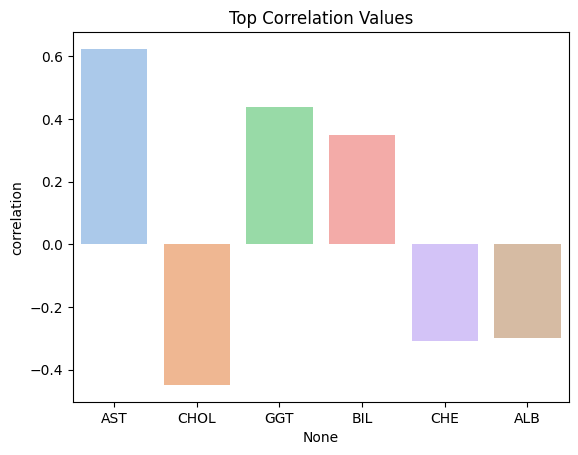

In [18]:
corr_with_label = abs(correlations['label'])
top_pairs = corr_with_label.nlargest(7).iloc[1:].index
top_corrs = correlations.loc[top_pairs, 'label'].values
top_corrs_series = pd.Series(data=top_corrs, index=top_pairs, name='correlation')

colors = sns.color_palette('pastel', n_colors=len(top_pairs))
plt.title('Top Correlation Values')
sns.barplot(x=top_corrs_series.index, y=top_corrs_series, palette=colors)


## Preprocessing

In [5]:
scaled_features= StandardScaler()

In [6]:
for col in hepatis.columns:
    if not (col== 'label' or col=='Sex'):
        hepatis[col]= scaled_features.fit_transform(hepatis[col].values.reshape(-1, 1))

In [7]:
hepatis.head(3)

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,label
0,-1.490132,0,0.354356,-0.436619,0.025169,-0.514554,0.082170,-0.236041,-0.419423,-0.072619,-0.272344,0.518696,0
1,-0.262474,0,0.088524,0.195318,0.456608,-0.380436,-0.338835,0.372642,0.086915,-0.180876,0.156923,-0.451086,0
2,0.681878,0,0.053080,-0.213057,-0.479283,-0.640783,-0.325363,-0.618418,0.006967,-0.072619,-0.545747,-0.522922,0


In [8]:
X = hepatis[hepatis.columns[:-1]]
labels = hepatis['label']

## NCV

In [9]:
ncv = EstWithNest(data=X,labels=labels)

In [ ]:
start = time.time()
results = ncv.nestedcv(rounds=5,trials=100,scoring='matthews_corrcoef',outer_split=5)
end = time.time()

  0%|          | 0/5 [00:00<?, ?it/s]

Round 1 out of 5



outer splits: 0it [00:00, ?it/s]
outer splits: 1it [13:22, 802.43s/it]

In [ ]:
results.head()

In [ ]:
results.shape

In [ ]:
print(f'Total time of nested CV: {(end-start)/60:.2f}')

In [ ]:
metrics = results.columns.drop('Estimator')
n_rows = 3
n_cols = 3

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(30, 20))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.set_style('whitegrid')
    data_melted = results.melt(id_vars=['Estimator'], value_vars=[metric], var_name='Metric', value_name='Score')
    sns.boxplot(x='Estimator', y='Score', data=data_melted, palette='pastel', ax=ax)
    ax.set_title(f'{metric} Score Distribution per Model')
    ax.set_xlabel('Model')
    ax.set_ylabel(f'{metric} Score')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

for j in range(i + 1, n_rows * n_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
mean_values = results.groupby('Estimator').mean().transpose()
std_values = results.groupby('Estimator').std().transpose()
heatmap_df = pd.concat([mean_values, std_values], axis=1, keys=['mean', 'std'])

sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_df, cmap="YlGnBu", center=0, annot=True, fmt=".2f", cbar_kws={'label': 'Score'}, square=True)
plt.xlabel('Model')
plt.ylabel('Metric')
plt.title('Mean and StD for every Model')
plt.show()

We keep the model with the best mean MCC score


In [ ]:
model_selection={}
for mod in results.Estimator.unique():
    model_selection[mod]=results[results.Estimator==mod].MCC.mean()

In [ ]:
model_selection

We can observe that Random Forest Estimator results the best mean combined with the smallest std. Thus, it is the most robust estimetor for this dataset.

## Train the most robust estimator

In [10]:
final_model = ncv.opt_final_sel(X=X,y=labels,estimator='RandomForestClassifier')

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
metrics = ['matthews_corrcoef', 'balanced_accuracy', 'f1', 'recall', 'precision', 'accuracy', 'roc_auc', 'average_precision'] 
scorers = {
    'MCC': 'matthews_corrcoef', 
    'Balanced_accuracy': 'balanced_accuracy',
    'F1': 'f1',
    'Recall': 'recall',
    'Precision': 'precision',
    'Accuracy': 'accuracy',
    'AUC': 'roc_auc',
    'Average_precision': 'average_precision'}

first_attempt = pd.DataFrame(columns=metrics)

for i in tqdm(range(10)):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    results = []
    for metric_name, scorer in scorers.items():
        score = cross_val_score(final_model, X=X, y=labels, cv=outer_cv, scoring=scorer)
        results.append(np.mean(score))
    first_attempt.loc[i] = results

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:48<00:00, 10.88s/it]


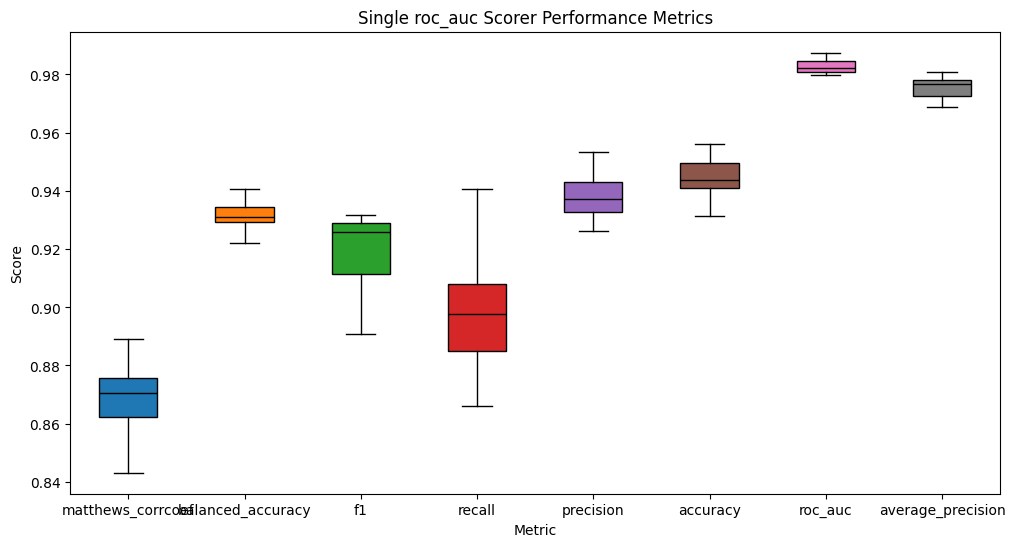

In [25]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']#, '#bcbd22', '#17becf']

plt.figure(figsize=(12,6))
boxplot = plt.boxplot(first_attempt, labels=metrics, patch_artist=True, boxprops=dict(facecolor='white', color='black'),
                      medianprops=dict(color='black'), whiskerprops=dict(color='black'), capprops=dict(color='black'))

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Single roc_auc Scorer Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')

plt.show()